In [75]:
import numpy as np
from pandas import pandas as pd
import time
import copy
from pprint import pprint

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import fbeta_score, make_scorer, classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

### Random dataframe

In [76]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

dt = pd.read_csv("dataset_fourth.csv", engine='python')
data = copy.copy(dt)
data.head()

,Unnamed: 0,icustay_id,mergeID,label,creatinine_tomorrow,creatinine_yesterday,creatinine_before_yesterday,arterial_pressure_systolic,arterial_pressure_systolic_delay,arterial_pressure_systolic_time,...,total_protein_urine_time,bilirubin,bilirubin_delay,bilirubin_time,c_reactive_protein,c_reactive_protein_delay,c_reactive_protein_time,ethnicity,diagnosis,gender
0,1,200001,200001 2181-11-26 05:36:00,0,3.5,NaN,NaN,NaN,NaN,NaN,...,NaN,0.2,0.0,2181-11-26 05:36:00,NaN,NaN,NaN,ASIAN - ASIAN INDIAN,ALTERED MENTAL STATUS,F
1,2,200001,200001 2181-11-27 05:54:00,1,2.9,2.7,NaN,NaN,NaN,NaN,...,NaN,0.2,87480.0,2181-11-26 05:36:00,NaN,NaN,NaN,ASIAN - ASIAN INDIAN,ALTERED MENTAL STATUS,F
2,3,200003,200003 2199-08-03 01:47:00,1,0.7,NaN,NaN,NaN,NaN,NaN,...,NaN,3.4,0.0,2199-08-03 01:47:00,NaN,NaN,NaN,WHITE,S/P RESECTION,M
3,4,200003,200003 2199-08-04 01:21:00,2,0.8,1.0,NaN,NaN,NaN,NaN,...,NaN,3.9,27840.0,2199-08-03 17:37:00,NaN,NaN,NaN,WHITE,S/P RESECTION,M
4,5,200003,200003 2199-08-05 02:25:00,2,0.7,0.7,1.0,NaN,NaN,NaN,...,NaN,4.7,0.0,2199-08-05 02:25:00,NaN,NaN,NaN,WHITE,S/P RESECTION,M


In [78]:
data = dt
min_max_scaler = preprocessing.MinMaxScaler()

# Features to use
feat_names_num = ['creatinine_yesterday', 'creatinine_before_yesterday',
              'urea', 'potassium',
              'platelet_count', 'ph_blood',
              'creatinine', 'age', 'bilirubin']
feat_names_cat = ['gender', 'ethnicity', 'diagnosis']
feat_names = feat_names_num + feat_names_cat

feat_lab = feat_names + ['label']

print('Initial data length: ', len(data))
data = data[feat_lab]

# Remove outliers
data = data[data['creatinine'] < 20]
data = data[data['creatinine_yesterday'] < 20]
data = data[data['creatinine_before_yesterday'] < 20]
data = data[data['potassium'] > 1.2]
data = data[data['ph_blood'] > 6]
data = data[data['age'] < 110]
data = data[data['bilirubin'] < 20]
data['gender'] = data['gender'].map({'F': 1, 'M': 0})

# Remove Nan
for name in feat_names:
    try:
        data = data[np.isfinite(data[name])]
    except:
        data = data[data[name].isnull() == False]

print('\nTotal entries: ', len(data))

# Normalize data
data[feat_names_num] = (data[feat_names_num] - 
                        data[feat_names_num].mean()) / (data[feat_names_num].max() - 
                                                        data[feat_names_num].min())
print(data.head())
print(data.isnull().sum())

Initial data length:  143048

Total entries:  47013
    creatinine_yesterday  creatinine_before_yesterday      urea  potassium  \
16             -0.047087                    -0.038678 -0.083167  -0.013952   
19             -0.053337                    -0.048729 -0.120204  -0.103383   
20             -0.065837                    -0.043704 -0.116088  -0.103383   
21             -0.065837                    -0.053754 -0.107858  -0.103383   
22             -0.065837                    -0.053754 -0.091397  -0.103383   

    platelet_count  ph_blood  creatinine       age  bilirubin  gender  \
16       -0.051882 -0.013191   -0.052767 -0.121117   0.648965       0   
19       -0.075239  0.116679   -0.074350  0.058413  -0.024401       0   
20       -0.066548  0.103692   -0.074350  0.058413  -0.024401       0   
21       -0.049166  0.103692   -0.074350  0.058413  -0.024401       0   
22       -0.011143  0.090705   -0.074350  0.058413  -0.024401       0   

                 ethnicity              

In [79]:
data['ethnicity'].unique()



data['ethnicity'] = data['ethnicity'].map({'BLACK/AFRICAN AMERICAN': 'BLACK', 
                                           'WHITE': 'WHITE', 
                                           'UNKNOWN/NOT SPECIFIED': 'NaN',
                                           'HISPANIC/LATINO - DOMINICAN': 'OTHER', 
                                           'UNABLE TO OBTAIN': 'NaN',
                                           'PATIENT DECLINED TO ANSWER': 'NaN', 
                                           'ASIAN - CHINESE': 'ASIAN',
                                           'AMERICAN INDIAN/ALASKA NATIVE': 'OTHER', 
                                           'MULTI RACE ETHNICITY': 'OTHER',
                                           'WHITE - OTHER EUROPEAN': 'WHITE', 
                                           'OTHER': 'OTHER', 
                                           'PORTUGUESE': 'WHITE',
                                           'HISPANIC OR LATINO': 'OTHER', 
                                           'ASIAN': 'ASIAN', 
                                           'HISPANIC/LATINO - PUERTO RICAN': 'OTHER',
                                           'MIDDLE EASTERN': 'OTHER', 
                                           'ASIAN - KOREAN': 'ASIAN', 
                                           'BLACK/HAITIAN': 'BLACK',
                                           'ASIAN - OTHER': 'ASIAN', 
                                           'HISPANIC/LATINO - CUBAN': 'OTHER', 
                                           'ASIAN - FILIPINO': 'ASIAN',
                                           'BLACK/CAPE VERDEAN': 'BLACK', 
                                           'WHITE - BRAZILIAN': 'WHITE', 
                                           'ASIAN - ASIAN INDIAN': 'ASIAN',
                                           'WHITE - EASTERN EUROPEAN': 'WHITE', 
                                           'HISPANIC/LATINO - GUATEMALAN': 'OTHER',
                                           'ASIAN - VIETNAMESE': 'ASIAN', 
                                           'HISPANIC/LATINO - MEXICAN': 'OTHER',
                                           'WHITE - RUSSIAN': 'WHITE', 
                                           'BLACK/AFRICAN': 'BLACK', 
                                           'ASIAN - CAMBODIAN': 'ASIAN',
                                           'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'OTHER'})
data['ethnicity'].unique()
data.tail()

,creatinine_yesterday,creatinine_before_yesterday,urea,potassium,platelet_count,ph_blood,creatinine,age,bilirubin,gender,ethnicity,diagnosis,label
143038,-0.072087,-0.048729,-0.103743,-0.046472,0.232203,0.012783,-0.074350,-0.295734,-0.079678,0,WHITE,STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES,2
143039,-0.065837,-0.058779,-0.111973,-0.046472,0.205587,0.012783,-0.081544,-0.295734,-0.079678,0,WHITE,STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES,2
143040,-0.072087,-0.053754,-0.099627,-0.046472,0.120850,0.012783,-0.074350,-0.295734,-0.079678,0,WHITE,STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES,2
143046,0.140413,0.182427,-0.004977,0.034829,-0.072523,-0.078126,0.184643,0.156646,-0.024401,1,WHITE,GALLSTONE;FAILED ERCP,0
143047,0.159163,0.112075,0.040290,0.034829,-0.064918,-0.091113,0.227809,0.156646,-0.024401,1,WHITE,GALLSTONE;FAILED ERCP,1


In [80]:
len(data['diagnosis'].unique())
diag_to_stay = ['PNEUMONIA', 'CONGESTIVE HEART FAILURE', 'SUBARACHNOID HEMORRHAGE',
               'INTRACRANIAL HEMORRHAGE', 'ALTERED MENTAL STATUS', 'CORONARY ARTERY DISEASE',
               'ABDOMINAL PAIN', 'CHEST PAIN', 'HYPOTENSION', 'ACUTE RENAL FAILURE',
               'RESPIRATORY FAILURE', 'GASTROINTESTINAL BLEED', 'PANCREATITIS', 'SEPSIS']
'YS' in data['diagnosis'].iloc[1]
for i in range(len(data['diagnosis'])):
    value = data['diagnosis'].iat[i]
    if 'FEVER' in value:
        data['diagnosis'].iat[i] = 'SEPSIS'
    elif 'DYSPNEA' in value or 'SHORTNESS OF BREATH' in value:
        data['diagnosis'].iat[i] = 'RESPIRATORY FAILURE'
    elif value not in diag_to_stay:
        data['diagnosis'].iat[i] = 'OTHER'
data['diagnosis'].unique()

array(['ALTERED MENTAL STATUS', 'OTHER', 'RESPIRATORY FAILURE',
       'HYPOTENSION', 'CONGESTIVE HEART FAILURE', 'CHEST PAIN', 'SEPSIS',
       'INTRACRANIAL HEMORRHAGE', 'GASTROINTESTINAL BLEED',
       'ACUTE RENAL FAILURE', 'PNEUMONIA', 'ABDOMINAL PAIN',
       'SUBARACHNOID HEMORRHAGE', 'CORONARY ARTERY DISEASE', 'PANCREATITIS'], dtype=object)

In [81]:
print(feat_names)
data = pd.get_dummies(data)
data.head()

['creatinine_yesterday', 'creatinine_before_yesterday', 'urea', 'potassium', 'platelet_count', 'ph_blood', 'creatinine', 'age', 'bilirubin', 'gender', 'ethnicity', 'diagnosis']


,creatinine_yesterday,creatinine_before_yesterday,urea,potassium,platelet_count,ph_blood,creatinine,age,bilirubin,gender,...,diagnosis_CORONARY ARTERY DISEASE,diagnosis_GASTROINTESTINAL BLEED,diagnosis_HYPOTENSION,diagnosis_INTRACRANIAL HEMORRHAGE,diagnosis_OTHER,diagnosis_PANCREATITIS,diagnosis_PNEUMONIA,diagnosis_RESPIRATORY FAILURE,diagnosis_SEPSIS,diagnosis_SUBARACHNOID HEMORRHAGE
16,-0.047087,-0.038678,-0.083167,-0.013952,-0.051882,-0.013191,-0.052767,-0.121117,0.648965,0,...,0,0,0,0,0,0,0,0,0,0
19,-0.053337,-0.048729,-0.120204,-0.103383,-0.075239,0.116679,-0.074350,0.058413,-0.024401,0,...,0,0,0,0,1,0,0,0,0,0
20,-0.065837,-0.043704,-0.116088,-0.103383,-0.066548,0.103692,-0.074350,0.058413,-0.024401,0,...,0,0,0,0,1,0,0,0,0,0
21,-0.065837,-0.053754,-0.107858,-0.103383,-0.049166,0.103692,-0.074350,0.058413,-0.024401,0,...,0,0,0,0,1,0,0,0,0,0
22,-0.065837,-0.053754,-0.091397,-0.103383,-0.011143,0.090705,-0.074350,0.058413,-0.024401,0,...,0,0,0,0,1,0,0,0,0,0


### Split data to train and test sets

In [82]:
y = data['label']
feat_names = list(data)
feat_names.remove('label')
X = data[feat_names]
X.head()

X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Split to three test sets
test_size = len(X_valid_test) // 2
X_validation = X_valid_test[0:test_size]
y_validation = y_valid_test[0:test_size]

X_test = X_valid_test[test_size:-1]
y_test = y_valid_test[test_size:-1]

### Process data for the keras model

In [83]:
# Prepare the data for the keras model
X_train_keras = np.array(X_train)[:,:]
X_train_keras = X_train_keras.astype('float32')
X_validation_keras = np.array(X_validation)[:,:]
X_validation_keras = X_validation_keras.astype('float32')
X_test_keras = np.array(X_test)[:,:]
X_test_keras = X_test_keras.astype('float32')

n_classes = 3
y_train_keras = keras.utils.to_categorical(y_train,n_classes)
y_validation_keras = keras.utils.to_categorical(y_validation,n_classes)
y_test_keras = keras.utils.to_categorical(y_test,n_classes)

# VERY IMPORTANT
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = dict(enumerate(class_weight))

print("CHECK DATA")
print("Shape of X:", X_train_keras.shape)
print("\nShape of y:", y_train_keras.shape)
print("\nFirst 10 rows of X")
print(X_train_keras[:10, :4])
print("\nFirst 10 rows of y")
print(y_train_keras[:10])

CHECK DATA
Shape of X: (37610, 30)

Shape of y: (37610, 3)

First 10 rows of X
[[-0.05958737 -0.04370362 -0.07493611 -0.04647229]
 [-0.04083737 -0.04872875  0.01148365 -0.01395196]
 [-0.05958737 -0.05375387 -0.09962747  0.02669844]
 [-0.06583738 -0.05375387 -0.07905133 -0.01395196]
 [-0.07208738 -0.04872875 -0.1202036   0.05921877]
 [ 0.00291263  0.04172352 -0.04612952 -0.00582188]
 [-0.04083737 -0.03365337 -0.08728179 -0.00582188]
 [-0.05333738 -0.04370362  0.05263591 -0.04647229]
 [ 0.24041262  0.18745217  0.2378211   0.05108869]
 [ 0.51541263  0.3934823   0.43123674  0.14864966]]

First 10 rows of y
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


### Model architecture

In [119]:
# Use only when wanting to optimize the SGD optimizer
# from keras.optimizers import SGD 

def create_model(neurons = [128, 64, 3],
                 dropout_rate=0.1, 
                 weight_constraint=0, 
                 init_mode='uniform',
                 optimizer='Adadelta',
                 # Sigmoid is the recommended activation 
                 # for multiclass classification problems
                 # (at least in the final layer)
                 activation = ['relu', 'relu', 'relu']):

    # Build the model architecture 
    model = Sequential()
    model.add(Dense(neurons[0], 
                    activation=activation[0], 
                    input_shape=(X_train_keras.shape[1],)))
    
                    # Uncomment to optimize dropout (don't forget to comment the previous activation variable)
                    # kernel_initializer='uniform', 
                    # activation='linear', 
                    # kernel_constraint=maxnorm(weight_constraint)))
                    
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons[1], activation=activation[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons[2], activation=activation[2]))

    # Use only when wanting to optimize the SGD optimizer (set optimizer=optimizer in model.compile())
    # optimizer = SGD(lr=learn_rate, momentum=momentum) 
    
    # Compile the model using a loss function and an optimizer.
    # 'sparse_categorical_crossentropy' is mandatory for multiclass classification!
    model.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

### Model performance (Grid search)

In [ ]:
# Uncomment according to which hyperparameters are necessary to be explored.

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the grid search parameters

# Use only to optimize SGD
# learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3] 
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

# The most basic parameters to optimize
batch_size = [10]
epochs = [30]

# Use to optimize number of neurons in layers
neurons = [[32, 16, 3]] #[[256, 128, 3], [128, 64, 3], [64, 32, 3], [32, 16, 3]]

# Optimize activation
activation = [['relu', 'relu', 'sigmoid']]#, ['relu', 'relu', 'softmax']] #[['relu', 'relu', 'sigmoid'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'softmax']]

# Use to optimize dropout
# weight_constraint = [1, 3]#[1, 2, 3, 4, 5] 
# dropout_rate = [0.0, 0.5]#[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Use to optimize the optimizer
# optimizer = ['SGD', 
#              'RMSprop', 
#              'Adagrad', 
#              'Adadelta', 
#              'Adam', 
#              'Adamax', 
#              'Nadam']

# Use to optimize initialization of weights
# init_mode = ['uniform', 
#              'lecun_uniform', 
#              'normal', 
#              'zero', 
#              'glorot_normal', 
#              'glorot_uniform', 
#              'he_normal', 
#              'he_uniform']

# Uncomment to optimize extra parameters
param_grid = dict(batch_size=batch_size, 
                  neurons=neurons,
                  activation=activation,
                  # weight_constraint=weight_constraint,
                  # dropout_rate=dropout_rate,
                  # optimizer=optimizer,
                  # init_mode=init_mode,
                  epochs=epochs)
                
# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta = 0.5, average = 'weighted')

# Perform grid search on the model
cv_sets = StratifiedShuffleSplit(n_splits=3, 
                                 test_size=0.1, 
                                 train_size=None, 
                                 random_state=seed)

start = time.time()

grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    fit_params={'class_weight': class_weight}, # VERY IMPORTANT 
                    # scoring=scorer,  
                    n_jobs=1, #-1
                    cv=cv_sets) 

grid_fit = grid.fit(X = X_train_keras, y = y_train)

end = time.time()
print("\nTime elapsed: ", (end - start)/60, " min")

# Get the estimator
best_clf = grid_fit.best_estimator_

# Summarize results
print("Best: %f using %s" % (grid_fit.best_score_, grid_fit.best_params_))
means = grid_fit.cv_results_['mean_test_score']
stds = grid_fit.cv_results_['std_test_score']
params = grid_fit.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Performance on the validation set

In [124]:
bst = best_clf

# Make predictions using the unoptimized and model
best_predictions = grid_fit.predict(X_validation_keras)

print("\nBest classifier: \n", grid_fit)
conf = confusion_matrix(y_validation, best_predictions)
print("\nConfusion matrix")
pprint(conf)

print("\nClassification report")
print(classification_report(y_validation, best_predictions))


Best classifier: 
 GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.1,
            train_size=None),
       error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x18c0bcef0>,
       fit_params={'class_weight': {0: 2.1389978956947053, 1: 1.7480014872652909, 2: 0.5100975166483569}},
       iid=True, n_jobs=1,
       param_grid={'epochs': [30], 'batch_size': [10], 'activation': [['relu', 'relu', 'relu'], ['relu', 'relu', 'softmax']], 'neurons': [[32, 16, 3]]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Confusion matrix
array([[ 265,  277,  203],
       [ 229,  507,  165],
       [ 205,  533, 2317]])

Classification report
             precision    recall  f1-score   support

          0       0.38      0.36      0.37       745
          1       0.38      0.56      0.46       901
          2       0.86      0.76      0.81      3055

avg / total       0.69      

### Final test set

In [123]:
best_predictions = best_clf.predict(X_test_keras)
conf = confusion_matrix(y_test, best_predictions)

print("Confusion matrix")
pprint(confusion_matrix(y_test, best_predictions))

print("\nClassification report")
print(classification_report(y_test, best_predictions))

Confusion matrix
array([[ 274,  257,  229],
       [ 243,  479,  186],
       [ 234,  508, 2291]])

Classification report
             precision    recall  f1-score   support

          0       0.36      0.36      0.36       760
          1       0.39      0.53      0.45       908
          2       0.85      0.76      0.80      3033

avg / total       0.68      0.65      0.66      4701



### Principal component analysis

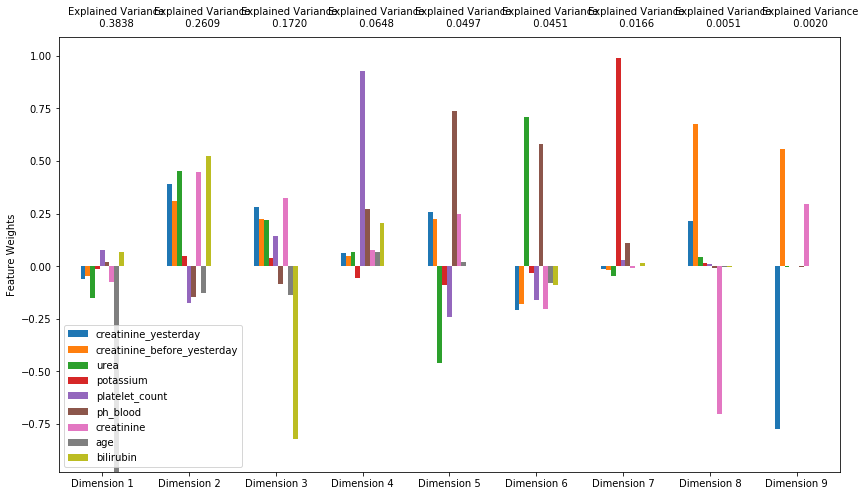

In [117]:
from sklearn.decomposition import PCA
import visuals as vs

pca = PCA(n_components = X[feat_names_num].shape[1], random_state= 42).fit(X[feat_names_num])

pca_results = vs.pca_results(X[feat_names_num], pca)